In [ ]:
# json file -> user_id, business_id 
import json
path = 'yelp_academic_dataset_review.json'
user_id = []
business_id = []
cnt = 0
for line in open(path):
   user_id.append(json.loads(line)["user_id"])
   business_id.append(json.loads(line)["business_id"])
   

In [ ]:
import numpy as np
user = []
business = []
rating = np.zeros([100,50])-np.ones([100,50])
non_empty = []

In [ ]:
# user_id, business_id 빈도가 많은 순으로 user, business에 저장 (초기 : user – 100개, business – 50개)
from collections import Counter
def add_top(user_num,bus_num,user_start):
    user_top = Counter(user_id).most_common(user_num)

    business_top = Counter(business_id).most_common(bus_num)
    cnt=0
    for id, num in user_top[user_start:]:
        user.append(id)
        
    for id, num in business_top:
        business.append(id)    
    


In [ ]:
# rating matrix 구현(size : 100*50)
def fill_rating():
    for line in open(path):
        check_user = json.loads(line)["user_id"]
        check_bus = json.loads(line)["business_id"]
        if ((check_user in user) and (check_bus in business)):
            if(rating[user.index(check_user),business.index(check_bus)] == -1):
                non_empty.append((check_user,check_bus))
                stars = json.loads(line)["stars"]
                rating[user.index(check_user),business.index(check_bus)] = stars


In [ ]:
# 각 row, column이 비어 있는지 확인하는 함수 
# 해당 데이터 셋의 경우 column은 해당사항 없어 비어 있는 row의 user_id만 출력.
def check_rating():
    row_check = []
    column_check = []
    for i,j in non_empty:
        if not i in row_check:
            row_check.append(i)
        if not j in column_check:
            column_check.append(j)

    row_check = list(set(user)-set(row_check))
    return row_check


In [ ]:
# 초기 100 * 50 matrix 구현
add_top(100,50,0)
fill_rating()

In [ ]:
# 비어있는 row 교체 (column 의 경우 없음)
user_need = 100
user_remove = check_rating()
length = len(user_remove)
while(length!=0):
    user_need += length
    for i in user_remove:
        user.remove(i)
    add_top(user_need,50,user_need-length)
    fill_rating()
    user_remove = check_rating()
    length = len(user_remove)


In [ ]:
# 명시된 조건에 맞게 split 시 필요한 check 함수
def check_row(matrix,row,column):
    for i in matrix[row,:column]:
        if i != -1:
            return True
    for i in matrix[row,column+1:]:
        if i != -1:
            return True
    return False        

def check_column(matrix,row,column):
    for i in matrix[:row,column]:
        if i != -1:
            return True
    for i in matrix[row+1:,column]:
        if i != -1:
            return True
    return False


In [ ]:
# split training and test
import random
random.seed(1)
test = 0
test_matrix = np.zeros([100,50])-np.ones([100,50])
non_empty_length = len(non_empty)
userID,busID = non_empty[random.randrange(0,non_empty_length)]
user_num = user.index(userID)
bus_num = business.index(busID)

chosen = rating[user_num,bus_num]

while(test < non_empty_length * 0.1):
    userID,busID = non_empty[random.randrange(0,non_empty_length)]
    user_num = user.index(userID)
    bus_num = business.index(busID)
    chosen = rating[user_num,bus_num]
    
    if chosen != -1:
        # check row, column is empty
        if check_row(rating,user_num,bus_num) and check_column(rating,user_num,bus_num):
            test_matrix[user_num,bus_num] = chosen
            rating[user_num,bus_num] = -1
            test+=1



In [ ]:
# 빈 matrix rating 0으로 교체.
for i in range(100):
  for j in range(50):
    if test_matrix[i,j] ==-1:
      test_matrix[i,j] = 0
for i in range(100):
  for j in range(50):
    if rating[i,j] ==-1:
      rating[i,j] = 0

    

In [ ]:
# matrix factorization 정의
import numpy as np

class MF():

    def __init__(self, R, K, alpha, beta, iterations):
        """
        Perform matrix factorization to predict empty
        entries in a matrix.

        Arguments
        - R (ndarray)   : user-item rating matrix
        - K (int)       : number of latent dimensions
        - alpha (float) : learning rate
        - beta (float)  : regularization parameter
        """

        self.R = R
        self.num_users, self.num_items = R.shape
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations

    def train(self):
        # Initialize user and item latent feature matrice
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))

        # Initialize the biases
        self.b_u = np.zeros(self.num_users)
        self.b_i = np.zeros(self.num_items)
        self.b = np.mean(self.R[np.where(self.R != 0 )]) # R = [1 2 0] -> self.b = mean([1 2]) = 1.5   np.mean(R) = 3/3 = 1

        # Create a list of training samples
        self.samples = [
            (i, j, self.R[i, j])
            for i in range(self.num_users)
            for j in range(self.num_items)
            if self.R[i, j] > 0
        ] # R = [[1,0], [0,2]]  --> self.samples = [(0,0,1), (1,1,2)]

        # Perform stochastic gradient descent for number of iterations
        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            mse = self.mse() # R(i,j) -> P(i,:) * Q.T(j,:) + b + b_i(i) + b_u(j)
            training_process.append((i, mse))
            if (i+1) % 10 == 0:
                print("Iteration: %d ; error = %.4f" % (i+1, mse))

        return training_process

    def mse(self):
        """
        A function to compute the total mean square error
        """
        xs, ys = self.R.nonzero()
        predicted = self.full_matrix()
        error = 0
        for x, y in zip(xs, ys):
            error += pow(self.R[x, y] - predicted[x, y], 2)
        return np.sqrt(error)

    def sgd(self):
        """
        Perform stochastic graident descent
        """
        for i, j, r in self.samples:
            # Computer prediction and error
            prediction = self.get_rating(i, j)
            e = (r - prediction)

            # Update biases
            self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])
            self.b_i[j] += self.alpha * (e - self.beta * self.b_i[j])

            # Update user and item latent feature matrices
            self.P[i, :] += self.alpha * (e * self.Q[j, :] - self.beta * self.P[i,:])
            self.Q[j, :] += self.alpha * (e * self.P[i, :] - self.beta * self.Q[j,:])

    def get_rating(self, i, j):
        """
        Get the predicted rating of user i and item j
        """
        prediction = self.b + self.b_u[i] + self.b_i[j] + self.P[i, :].dot(self.Q[j, :].T)
        return prediction

    def full_matrix(self):
        """
        Computer the full matrix using the resultant biases, P and Q
        """
        return self.b + self.b_u[:,np.newaxis] + self.b_i[np.newaxis:,] + self.P.dot(self.Q.T)

In [ ]:
# test case의 loss를 확인하기 위함
def mse(matrix,predicted):
        """
        A function to compute the total mean square error
        """
        xs, ys = matrix.nonzero()
        
        error = 0
        for x, y in zip(xs, ys):
            error += pow(matrix[x, y] - predicted[x, y], 2)
        return np.sqrt(error)

In [ ]:
# iteration 에 따른 loss 변화 ploting
import matplotlib.pyplot as plt
def plot(train_loss,rank):
  iter = []
  loss = []
  for x, y in train_loss:
    iter.append(x)
    loss.append(y)
  plt.plot(iter,loss)
  plt.title("rank size ="+ str(rank))
  plt.xlabel("iteration")
  plt.ylabel("loss")
  plt.show()

In [ ]:
# rank에 따른 train,plot,test_loss 출력
def train_by_rank(rank):
  mf = MF(rating, K=rank, alpha=0.1, beta=0.05, iterations=50)
  train_loss = mf.train()
  test_loss = mse(test_matrix,mf.full_matrix())
  plot(train_loss,rank)
  test_loss = mse(test_matrix,mf.full_matrix())
  print("Test loss : ",test_loss)

Iteration: 10 ; error = 15.7200
Iteration: 20 ; error = 14.1066
Iteration: 30 ; error = 13.3281
Iteration: 40 ; error = 12.8474
Iteration: 50 ; error = 12.7680


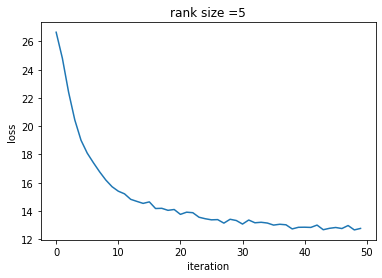

Test loss :  11.26838282818237
Iteration: 10 ; error = 9.9270
Iteration: 20 ; error = 7.5668
Iteration: 30 ; error = 7.0259
Iteration: 40 ; error = 6.7554
Iteration: 50 ; error = 6.8082


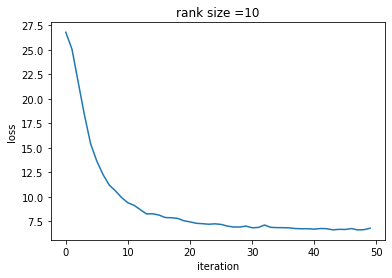

Test loss :  9.479903175698086
Iteration: 10 ; error = 8.9699
Iteration: 20 ; error = 6.2949
Iteration: 30 ; error = 5.8107
Iteration: 40 ; error = 5.5398
Iteration: 50 ; error = 5.2934


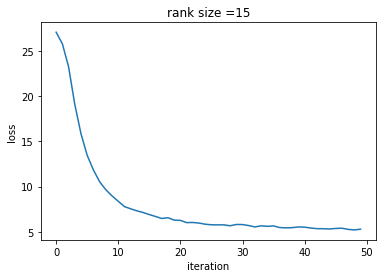

Test loss :  8.992487042055245
Iteration: 10 ; error = 8.3245
Iteration: 20 ; error = 5.6888
Iteration: 30 ; error = 5.3150
Iteration: 40 ; error = 5.0078
Iteration: 50 ; error = 4.9590


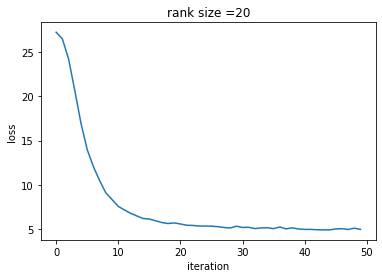

Test loss :  8.93851448788218


In [ ]:
# train
train_by_rank(5)
train_by_rank(10)
train_by_rank(15)
train_by_rank(20)